Adam Prado
4/8/24

Chapter 7, Applied #6, Python

imports all of the libraries used in chapter 7 and 5.  

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

In [3]:
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



Download data set

In [4]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

Splits data into training and validation set. 

In [5]:
Wage_train, Wage_valid = train_test_split(Wage, test_size=1500, random_state=0)
Wage_valid.shape

(1500, 11)

In [6]:

y_train = Wage_train['wage']
age_train = Wage_train['age']

y_valid = Wage_valid['wage']
age_valid = Wage_valid['age']

testing out a single polynomial function with degree 4

In [7]:
poly_age = MS([poly('age',degree=4)]).fit(Wage_train)
M = sm.OLS(y_train, poly_age.transform(Wage_train)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,112.0572,1.016,110.311,0.000
"poly(age, degree=4)[0]",297.9902,39.343,7.574,0.000
"poly(age, degree=4)[1]",-364.1589,39.343,-9.256,0.000
"poly(age, degree=4)[2]",73.4079,39.343,1.866,0.062
"poly(age, degree=4)[3]",-29.3780,39.343,-0.747,0.455


Testing out using "PolynomialFeatures" instead of the way the textbook lab did it.  This seemed a bit more straightforward to me, not sure if it creates issues later.

In [8]:
X = Wage[['age']]
y = Wage['wage']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)


poly_features = PolynomialFeatures(degree=4)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred = poly_reg.predict(X_val_poly)

mse = mean_squared_error(y_val, y_pred)
print("MSE:", mse)

MSE: 1641.3963961092693


Sets up for loop to try all polynomial degrees from 1 to 19 and calculates the MSE

In [9]:
for i in range(1,20):
    poly_features = PolynomialFeatures(degree=i)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_val)

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)

    y_pred = poly_reg.predict(X_val_poly)

    mse = mean_squared_error(y_val, y_pred)
    print("MSE:",i," : ", mse)

MSE: 1  :  1713.6540183636291
MSE: 2  :  1650.282651885093
MSE: 3  :  1643.889879093827
MSE: 4  :  1641.3963961092693
MSE: 5  :  1642.3912084085687
MSE: 6  :  1640.493596285823
MSE: 7  :  1640.768108133873
MSE: 8  :  1640.2525386513794
MSE: 9  :  1640.3045217431138
MSE: 10  :  1640.4484244260834
MSE: 11  :  1640.362690986465
MSE: 12  :  1640.281601664193
MSE: 13  :  1641.1146384037004
MSE: 14  :  1650.6694901435606
MSE: 15  :  1664.7573591346256
MSE: 16  :  1681.5716036265635
MSE: 17  :  1699.090585536015
MSE: 18  :  1715.646283074408
MSE: 19  :  1730.1605999506655


The improvements to MSE continue to decrees until degree 4, there are some slightly lower MSE at higher levels but not worth overcomplicated the model.  This is the similar to the anova results. 

In [10]:
def plot_wage_fit(age_df,basis,title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y,X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]],['b', 'r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    return ax
    

Graph of the degree 4 polynomial. 

<Axes: title={'center': 'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

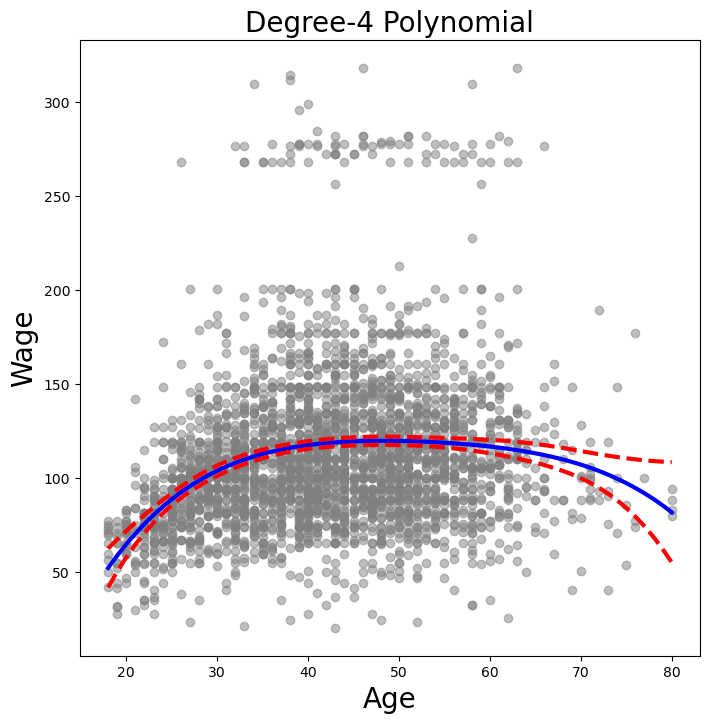

In [11]:
age_grid = np.linspace(age.min(), age.max(),100)
age_df = pd.DataFrame({'age':age_grid})
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

In [17]:
cut_age = pd.qcut(age_train,4)
stepModel = sm.OLS(y_train,pd.get_dummies(cut_age)).fit()
summarize(stepModel)

,coef,std err,t,P>|t|
"(17.999, 33.0]",95.2359,2.059,46.259,0.0
"(33.0, 42.0]",115.3765,2.051,56.264,0.0
"(42.0, 51.0]",121.4547,1.999,60.767,0.0
"(51.0, 80.0]",115.9094,2.158,53.702,0.0


In [19]:
y_pred = stepModel.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
print("MSE:",i," : ", mse)

ValueError: shapes (1500,1) and (4,) not aligned: 1 (dim 1) != 4 (dim 0)